# Outline


*   Step 1: Download and visualize the data with lables
*   Step 2: Preprocess the Dataset
*   Step 3: Split the data into Train and Test Set
*   Step 4: Implement the ConvLSTM Approch
    *   Step 4.1: Construct the model
    *   Step 5.1: Compile & Train the Model
    *   Step 4.3: Plot Model's Loss & Accuracy Curves
*   Step 5: Implement the LRCN Approch
    *   Step 5.1: Construct the Model
    *   Step 5.2: Compile & Train the Model
    *   Step 5.3: Plot Model's Loss & Accuracy Curves
*   Step 6: Test the best performing Model on Youtube Video








In [ ]:
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=77f9b13d6f834155cc8bc377d9f04f690f47f729b7c511ddbed9df389f4ea937
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


In [ ]:
#Discard the output of the cell.
%%capture

# Install the required libraries
!pip install pafy youtube-dl moviepy

In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2383872/45929032 bytes (5.2%)5128192/45929032 bytes (11.2%)8511488/45929032 bytes (18.5%)11755520/45929032 bytes (25.6%)15114240/45929032 bytes (32.9%)18276352/45929032 bytes (39.8%)21544960/45929032 bytes (46.9%)24715264/45929032 bytes (53.8%)28123136/45929032 bytes (61.2%)31498240/45929032 bytes (68.6%)34979840/45929032 bytes (76.2%)38445056/45929032 bytes (83.7%)

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 1: Download and visualize the data with labels

The Dataset contains:

*   50 Action Categories
*   25 Groups of Videos per Action Category
*   133 avg. videos per action category
*   199 avg. number of frames per video
*   320 avg. frames width per video
*   240 avg. frames height per video
*   26 avg. frames per seconds per video




In [ ]:
%%capture

# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar  # linux command to unpack a zip file

# Extract the dataset
!unrar x UCF50

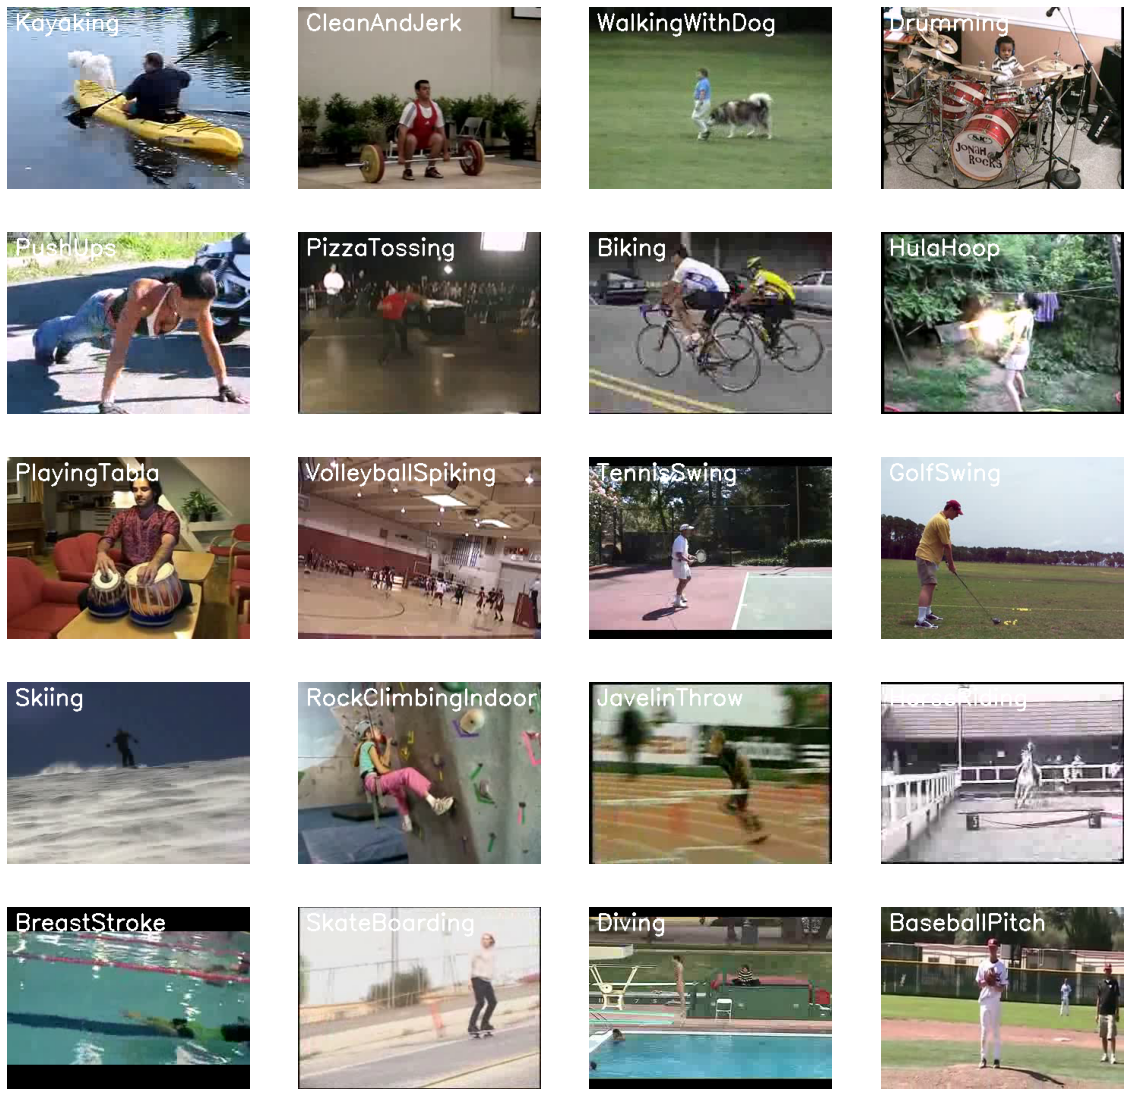

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize= (20, 20))

# Get the name of all classes/categories in UCF50
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the random total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

  # Retrieve a Class Name using th random Index.
  selected_class_Name = all_classes_names[random_index]

  # Retrieve the list of all the video files present in the randomly selected Class Directory.
  video_file_names_list = os.listdir(f'UCF50/{selected_class_Name}')

  #Randomly select a video file from the list retrived from the randomly selected Class Directory.
  selected_video_file_name = random.choice(video_file_names_list)

  # Initialize a VideoCapture object to read from the video File.
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  # Read the first frame of the video file.
  _, brg_frame = video_reader.read()

  # Release the VideoCapture object.
  video_reader.release()

  # Convert the frame from BGR into RGB format.
  rgb_frame = cv2.cvtColor(brg_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  # Display the frame.
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 2: Process the Dataset

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the nummber of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing th UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
def frames_extraction(video_path):
  '''
  This function will extract the required frames from a video after resizing and normalizing them.
  Args:
    video_path: The path of the video in the disk, whose frames are to be extracted
  Return:
    frames_list: A list containing the resized and noramalized frames of the video.
  '''

  # Declare a list to store video frames.
  frames_list = []

  # Read the video file using the videocapture object
  video_reader = cv2.VideoCapture(video_path)

  # Get the total number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate through the video frames.
  for frame_counter in range(SEQUENCE_LENGTH):
      
      # Set the current frame position of the video.
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

      # Reading the frame from the video.
      success, frame = video_reader.read()

      # Check if Video frame is not successfully read then break the loop
      if not success:
        break

      # Resize the Frame to fixed height and width.
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

      # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = resized_frame / 255

      # Append the noramlized frmae into the frames list
      frames_list.append(normalized_frame)

  # Release the videoCapture object.
  video_reader.release()

  # Return the frames list.
  return frames_list

# Create a Function for dataset Creation

In [ ]:
def create_dataset():
  '''
  This function will extract the data of the selcted classes and create the required dataset.
  Returns:
    features:          A list containing the extracted frames of the videos.
    labels:            A list containing the indexes of the classes associated with the videos.
    video_files_paths: A list containing the paths of the videos in the disk.
  '''

  # Declared Empty Lists to store the features, labels and video file path values.
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):
      # Display the name of the class whose data is being extracted.
      print(f'Extracting Data of class: {class_name}')

      # Get the list of video files present in the specific class name directory.
      files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

      # Iterate through all the files present in the files list.
      for file_name in files_list:

        # Get the complete video path.
        video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

        # Extract the frames of the video file
        frames = frames_extraction(video_file_path)

        # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
        # So ignore the video having frames less than the SEQUENCE_LENGTH.
        if len(frames) == SEQUENCE_LENGTH:

          # Append the data to their respective lists.
          features.append(frames)
          labels.append(class_index)
          video_files_paths.append(video_file_path)

  # Converting the list to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)

  # Return the frames, class index, and video file path.
  return features, labels, video_files_paths

In [ ]:
# Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of class: WalkingWithDog
Extracting Data of class: TaiChi
Extracting Data of class: Swing
Extracting Data of class: HorseRace


In [ ]:
# Using Keras to categories method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# 3: Split the Data into Train and Test Set

In [ ]:
# Split the Data into (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                           test_size = 0.25, shuffle = True,
                                                                           random_state=seed_constant)

# 4: Implement the ConvLSTM Approch

# 4.1: Contruct the Model

In [ ]:
def create_convlstm_model():
  '''
  This function will constuct the required convlstlm model.
  Return:
      model: It is the required constructed convlstm model.
  '''

  # We will use a Sequential model for model contruction 
  model = Sequential()

  # Define the model Architecture
  model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = 'tanh', data_format="channels_last", 
                       recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                     IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation='tanh', data_format="channels_last",
                       recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3,3), activation='tanh', data_format="channels_last",
                       recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3,3), activation='tanh', data_format="channels_last",
                       recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
  # model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  #Display the models summary.
  model.summary()

  # Return the constructed convlstm model.
  return model

In [ ]:
# Contruct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

# Check model's Structure:

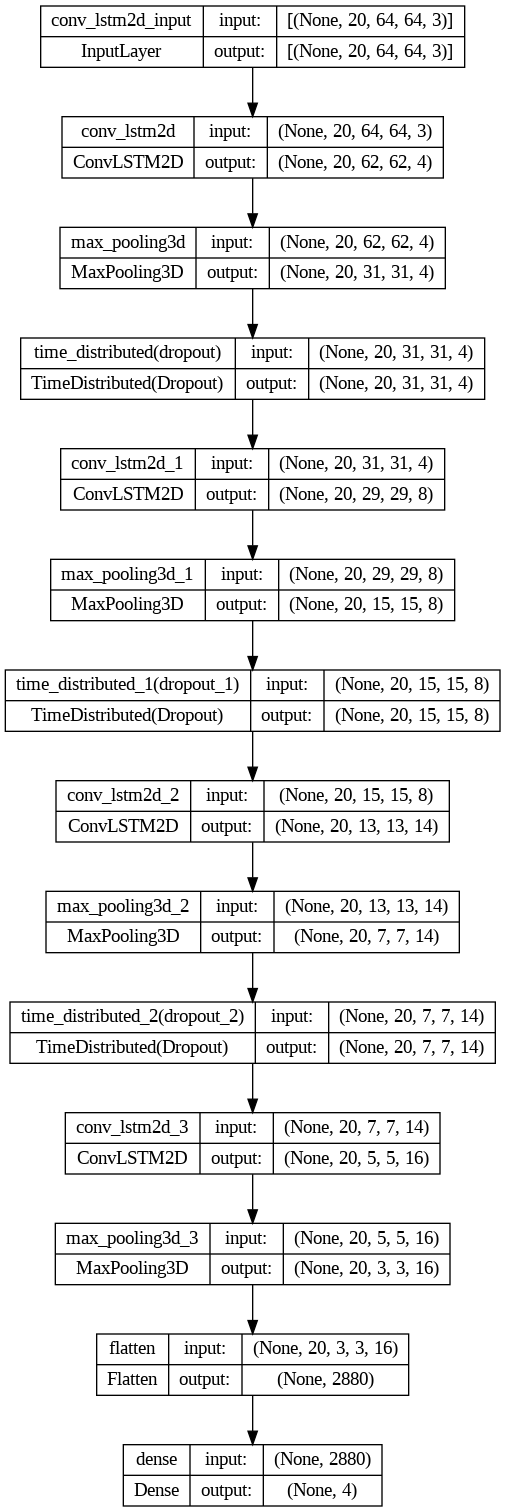

In [ ]:
# plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# 4.2: Compile & Train the model

In [ ]:
from sklearn.utils import validation
# Create an Instance of the Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs=3, batch_size=4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/3
73/73 [==============================] - 177s 2s/step - loss: 1.3239 - accuracy: 0.3938 - val_loss: 1.2947 - val_accuracy: 0.4247
Epoch 2/3
73/73 [==============================] - 176s 2s/step - loss: 1.1655 - accuracy: 0.4966 - val_loss: 1.1726 - val_accuracy: 0.4384
Epoch 3/3
73/73 [==============================] - 173s 2s/step - loss: 0.9972 - accuracy: 0.6130 - val_loss: 1.3631 - val_accuracy: 0.3288


In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 16s 4s/step - loss: 1.1068 - accuracy: 0.4098


# Save the Model

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to String according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

# 4.3: Plot model's Loss & Accuracy Curves

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
  This function will plot the metrics passed to it in a graph.
  Args:
      model_training_history: A history object containing a record of training and validation 
                              loss value and metrics value at successive epochs
      metric_name_1:          The name of the first metric that needs to be plotted in the graph.
      metric_name_2:          The name of the second metric that needs to be plotted in the graph.
      plot_name:              The title of the graph.
  '''

  # Get metric values using metric names as identifiers.
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Contruct a range object which will be used as x-axis (horizontal plane) of the graph.
  epochs = range(len(metric_value_1))

  # Plot the Graph.
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Add title to the plot.
  plt.title(str(plot_name))

  # Add legend to the plot
  plt.legend()

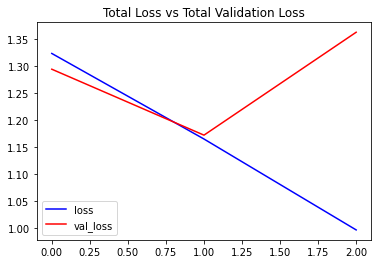

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

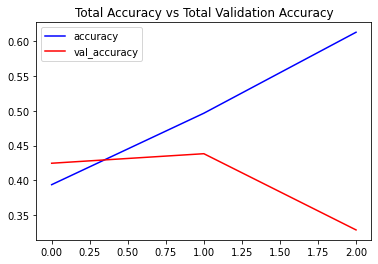

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# 5: Implement the LRCN Approch

In [ ]:
def create_LRCN_model():
  '''
  This function will construct the required LRCN model.
  Returns:
    model: It is the required constructed LRCN model.
  '''

  # We will use a Sequential model for model construction
  model = Sequential()

  # Define the Model Architecture
  #############################################################################

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  ################################################################################

  # Display the models summary.
  model.summary()

  # Return the constructed LRCN model.
  return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

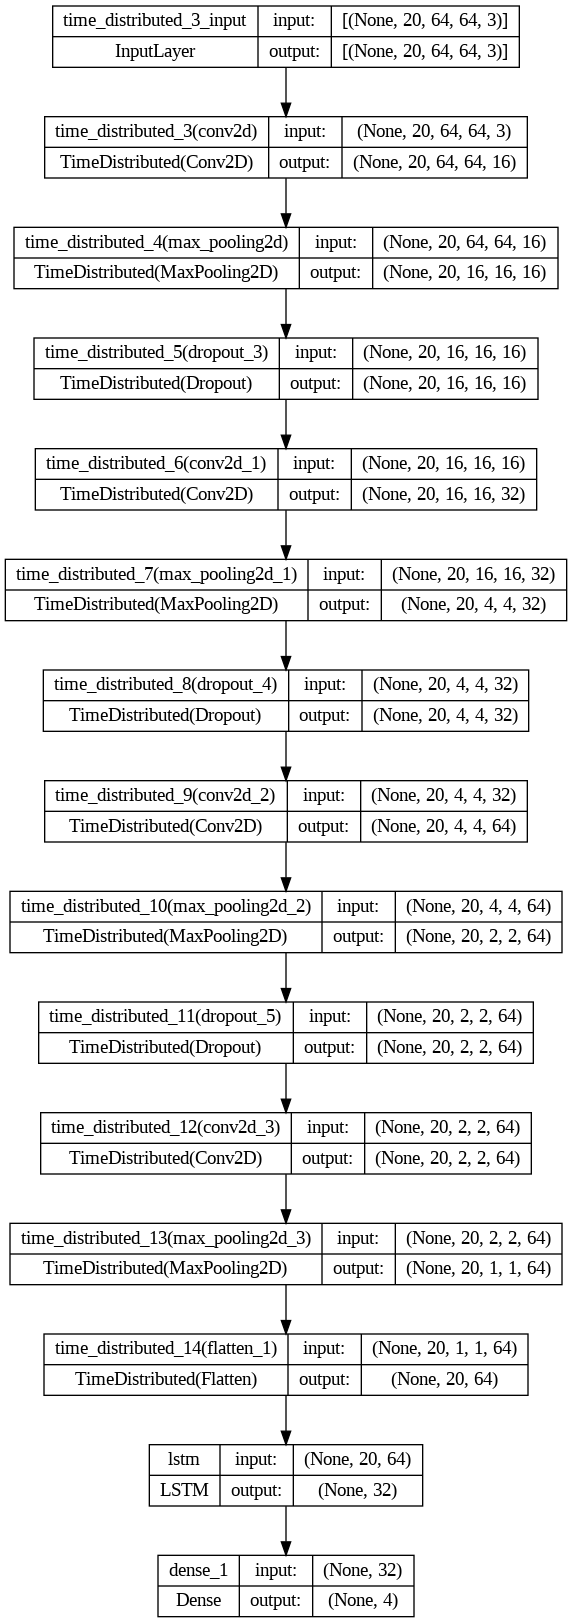

In [ ]:
# Plot the structure of the constructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=30, batch_size=4, shuffle=True, validation_split=0.2, callbacks = [early_stopping_callback])

Epoch 1/30
73/73 [==============================] - 33s 393ms/step - loss: 1.1309 - accuracy: 0.5068 - val_loss: 1.1157 - val_accuracy: 0.5205
Epoch 2/30
73/73 [==============================] - 20s 270ms/step - loss: 1.0858 - accuracy: 0.5137 - val_loss: 1.2391 - val_accuracy: 0.4247
Epoch 3/30
73/73 [==============================] - 20s 275ms/step - loss: 0.9394 - accuracy: 0.6130 - val_loss: 1.8512 - val_accuracy: 0.2877
Epoch 4/30
73/73 [==============================] - 24s 330ms/step - loss: 0.8670 - accuracy: 0.6233 - val_loss: 1.1990 - val_accuracy: 0.4932
Epoch 5/30
73/73 [==============================] - 20s 271ms/step - loss: 0.7512 - accuracy: 0.7158 - val_loss: 0.9260 - val_accuracy: 0.6438
Epoch 6/30
73/73 [==============================] - 19s 266ms/step - loss: 0.7361 - accuracy: 0.7123 - val_loss: 1.1998 - val_accuracy: 0.6164
Epoch 7/30
73/73 [==============================] - 20s 281ms/step - loss: 0.6076 - accuracy: 0.7637 - val_loss: 1.0370 - val_accuracy: 0.5890

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 4s 910ms/step - loss: 0.3514 - accuracy: 0.8607


# Save the Model

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

# Plot Model's Loss & Accuracy Curves

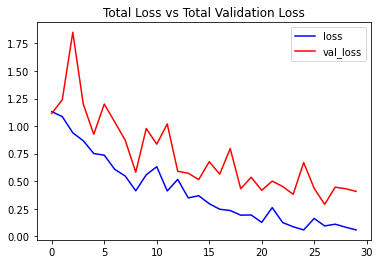

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

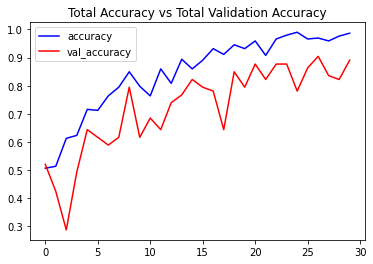

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# 6: Test the best performing Model on Youtube Video

In [ ]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytube import YouTube
def download_youtube_videos(youtube_video_url, output_directory):
  '''
  This function downloads the youtube video whose URL is passes to it as an argument.
  Args:
    youtube_video_url: URL of the video that is required to be downloaded.
    output_directory: The directory path to which the video needs to be stored after downloading.
  Returns:
    title: The title of the downloaded youtube video.
  '''
  # Create a video object which contains useful information about the video.
  d_video = YouTube(youtube_video_url)

  # Retrieve the title of the video.
  title = d_video.title

  # Get the best available quality object for the video.
  # video_best = video.getbest()

  # Construct the output file path.
  output_file_path = f'{output_directory}/{title}.3gpp'

  stream = d_video.streams.first()
  # Download the youtube video at the best available quality and store it to the constructed path.
  stream.download()

  # Return the video title.
  return title

# Download a Test Video

In [ ]:
# Make the output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.3gpp'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
  '''
  This function will perform action recognition on a video using the LRCN model.
  Args:
    video_file_path: The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the output video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH: The fixed number of frames of a video that can be passes to the model as one sequence.
  '''

  # Initialize the VideoCapture object to read from the video file.
  video_reader = cv2.VideoCapture(video_file_path)

  # Get the width and height of the video.
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Initalize the VideoWriter Object to store the output video in the disk.
  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

  # Declare a queue to store video frames.
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  # Initialize a variable to store the predicted action being performed in the video.
  predicted_class_name = ''

  # Iterate until the video is accessed successfully.
  while video_reader.isOpened():

    # Read the frame.
    ok, frame = video_reader.read()

    # Check if frame is not read properly then break the loop.
    if not ok:
      break

    # Resize the Frame to fixed Dimensions.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize he resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame / 255

    # Appending the pre-processed frmae into the frames list.
    frames_queue.append(normalized_frame)

    # Check if the number of frames in the queue are equal to the fixed sequence length
    if len(frames_queue) == SEQUENCE_LENGTH:

        # Pass the normalized frames to the model and get the predicted probabilities.
        predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

        # Get the index of class with highest probability.
        predicted_label = np.argmax(predicted_labels_probabilities)

        # Get the class name using the retrieved index.
        predicted_class_name = CLASSES_LIST[predicted_label]

    # Write predicted class name on top of the frame.
    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Write the frame into the disk using the VideoWriter object.
    video_writer.write(frame)

  # Release the VideoCapture and VideoWriter
  video_reader.release()
  video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300, None)).ipython_display()

1/1 [==============================] - 0s 76ms/step


100%|██████████| 217/217 [00:00<00:00, 251.25it/s]
